# Notebook to calcualte Potential Surface

In [2]:
import numpy as np

def beh2_coords(r, theta_deg):
    theta = np.deg2rad(theta_deg)
    y = r * np.sin(theta/2)
    z = r * np.cos(theta/2)
    return f"Be 0 0 0; H 0 {y:.6f} {z:.6f}; H 0 {-y:.6f} {z:.6f}"

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
import json

# r_array = np.linspace(1.0, 2.0, 25)
# theta_array = np.linspace(60, 180, 25)

r_array  = np.linspace(1.0, 2.0, 25)
theta_array = np.linspace(60, 180, 25)

dataset = []

for r in r_array:
    for theta in theta_array:
        atom_string = beh2_coords(r, theta)
        print(f'Processing r={r:.3f}, theta={theta:.1f} degrees')
        
        # initialise driver
        driver = PySCFDriver(
            atom=atom_string,
            basis="sto3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        # Generate Hamiltonian
        problem = driver.run()
        fermionic_op = problem.hamiltonian.second_q_op() # Fermionic Hamiltonian operator
        total_energy = problem.reference_energy # Energy of the system
        print('Hamiltonain energy:', total_energy)

        # Convert to Pauli Strings
        mapper = JordanWignerMapper()
        qubit_jw_op = mapper.map(fermionic_op)

        # Solve for ground state
        solver = NumPyEigensolver(k=1)
        result = solver.compute_eigenvalues(qubit_jw_op)
        ground_state_vector = result.eigenstates[0].data

        # Remove near-zero amplitudes
        cleaned_ground_state = [0 if abs(ampl) < 1e-12 else ampl for ampl in ground_state_vector]
        print(f'Non-zero amplitudes: {sum(abs(a)>0 for a in cleaned_ground_state)}')  
        
        cleaned_state_json = [[a.real, a.imag] for a in cleaned_ground_state]
        
        # Write to file (r, theta, total_energy, zero_ground_state)
        entry = {
            "r": float(r),
            "theta": float(theta),
            "energy": total_energy,
            "statevector": cleaned_state_json,
        }
        
        dataset.append(entry)
        

# with open("beh2_states_dataset.json", "w") as f:
#     json.dump(dataset, f, indent=2)

print("beh2_states_dataset.json")

Processing r=1.000, theta=60.0 degrees
Hamiltonain energy: -15.260761744461437
Non-zero amplitudes: 674
Processing r=1.000, theta=65.0 degrees
Hamiltonain energy: -15.282421927157849
Non-zero amplitudes: 322
Processing r=1.000, theta=70.0 degrees
Hamiltonain energy: -15.302115668906403
Non-zero amplitudes: 321
Processing r=1.000, theta=75.0 degrees
Hamiltonain energy: -15.320008675510184
Non-zero amplitudes: 321
Processing r=1.000, theta=80.0 degrees
Hamiltonain energy: -15.336221594534106
Non-zero amplitudes: 321
Processing r=1.000, theta=85.0 degrees
Hamiltonain energy: -15.350865188896314
Non-zero amplitudes: 321
Processing r=1.000, theta=90.0 degrees
Hamiltonain energy: -15.364058680507775
Non-zero amplitudes: 321
Processing r=1.000, theta=95.0 degrees
Hamiltonain energy: -15.375921300417168
Non-zero amplitudes: 321
Processing r=1.000, theta=100.0 degrees
Hamiltonain energy: -15.386576322688157
Non-zero amplitudes: 321
Processing r=1.000, theta=105.0 degrees
Hamiltonain energy: -15

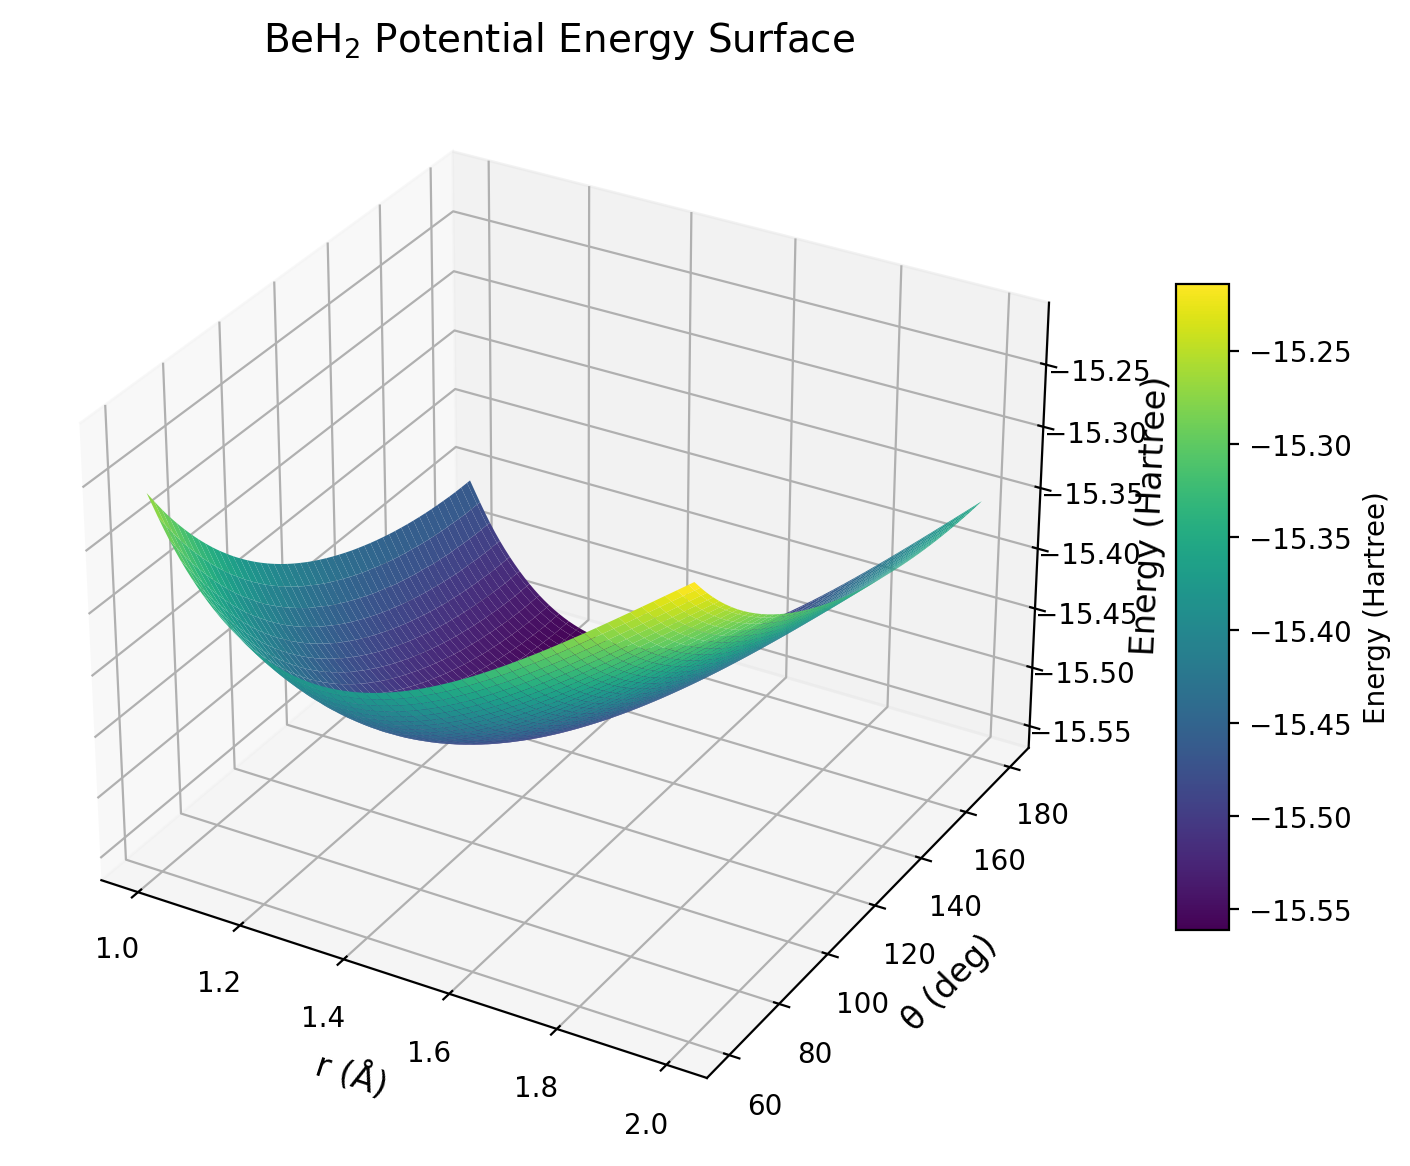

In [18]:
# Plot potential surface
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

# --- Load dataset ---
with open("beh2_states_dataset.json") as f:
    data = json.load(f)

# Extract r, theta, energy
r_vals = np.array([entry["r"] for entry in data])
theta_vals = np.array([entry["theta"] for entry in data])
energy_vals = np.array([entry["energy"] for entry in data])

# --- Create grid for plotting ---
r_grid = np.linspace(r_vals.min(), r_vals.max(), 100)
theta_grid = np.linspace(theta_vals.min(), theta_vals.max(), 100)
R, T = np.meshgrid(r_grid, theta_grid)

# Interpolate energies to grid
E_grid = griddata((r_vals, theta_vals), energy_vals, (R, T), method='cubic')

# --- Plot 3D surface ---
fig = plt.figure(figsize=(10, 7), dpi = 200)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(R, T, E_grid, cmap=cm.viridis, linewidth=0, antialiased=True)

ax.set_xlabel("r (Å)", fontsize=12)
ax.set_ylabel("θ (deg)", fontsize=12)
ax.set_zlabel("Energy (Hartree)", fontsize=12)
ax.set_title("BeH$_2$ Potential Energy Surface", fontsize=14)

fig.colorbar(surf, shrink=0.6, aspect=12, label="Energy (Hartree)")
# ax.view_init(elev=30, azim=45)
plt.show()